# Continuation Power Flow

Demonstrates continuation power flow (CPF) analysis for voltage stability
assessment. The notebook sets up interface transfers, runs the CPF solver
to trace the PV curve, and visualizes the nose point that marks the voltage
stability limit.

In [1]:
import numpy as np
from esapp import PowerWorld
from esapp.components import *
from examples.statics import Statics

In [2]:
# This cell is hidden in the documentation.
import ast

with open('../data/case.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

pw = PowerWorld(case_path)

'open' took: 9.6130 sec


In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import plot_pv_curve

## 1. Define Interface Transfer

The continuation power flow traces the PV curve by increasing a transfer
pattern (the `interface` vector) and solving power flow at each step. It uses
a predictor-corrector method with tangent vectors from the augmented Jacobian
for accurate nose-point tracking.

In [ ]:
s = Statics(pw)

# Solve base case
V_base = pw.pflow()
print(f"Base case min voltage: {np.abs(V_base).min():.4f} pu")

# Critical bus: lowest voltage magnitude
critical_bus_idx = np.argmin(np.abs(V_base))
print(f"Critical bus index: {critical_bus_idx}")
print(f"Critical bus voltage: {np.abs(V_base[critical_bus_idx]):.4f} pu")

# Build interface vector: uniform load increase at all buses
n_buses = 
interface = np.zeros(pw.n_bus)
interface /= np.sum(interface)  # normalize to 1 MW total
interface

Base case min voltage: 0.9749 pu
Critical bus index: 10
Critical bus voltage: 0.9749 pu


## 2. PV Curve

The PV curve shows how voltage at a critical bus varies with increasing
power transfer. The nose point indicates the maximum transfer before
voltage collapse.

In [13]:
# Collect PV curve data points
mw_points = []
v_points = []

for mw in s.continuation_pf(
    interface=-interface,
    initialmw=0,
    step_size=0.05,
    min_step=0.001,
    max_step=5,
    maxiter=1000,
    verbose=True,
    restore_when_done=True,
):
    V = pw.voltage()
    v_critical = np.abs(V[critical_bus_idx])
    mw_points.append(mw)
    v_points.append(v_critical)

print(f"\nCollected {len(mw_points)} points")
if mw_points:
    print(f"Transfer range: {min(mw_points):.1f} to {max(mw_points):.1f} MW")

  [0] Predict: lam=0.05 MW  (step=0.0500, dlam=0.05)  OK (lam=0.05)
  [1] Predict: lam=0.12 MW  (step=0.0750, dlam=0.08)  OK (lam=0.12)
  [2] Predict: lam=0.24 MW  (step=0.1125, dlam=0.11)  OK (lam=0.24)
  [3] Predict: lam=0.41 MW  (step=0.1688, dlam=0.17)  OK (lam=0.41)
  [4] Predict: lam=0.66 MW  (step=0.2531, dlam=0.25)  OK (lam=0.66)
  [5] Predict: lam=1.04 MW  (step=0.3797, dlam=0.38)  OK (lam=1.04)
  [6] Predict: lam=1.61 MW  (step=0.5695, dlam=0.57)  OK (lam=1.61)
  [7] Predict: lam=2.46 MW  (step=0.8543, dlam=0.85)  OK (lam=2.46)
  [8] Predict: lam=3.74 MW  (step=1.2814, dlam=1.28)  OK (lam=3.74)
  [9] Predict: lam=5.67 MW  (step=1.9222, dlam=1.92)  OK (lam=5.67)
  [10] Predict: lam=8.55 MW  (step=2.8833, dlam=2.88)  OK (lam=8.55)
  [11] Predict: lam=12.87 MW  (step=4.3249, dlam=4.32)  OK (lam=12.87)
  [12] Predict: lam=17.87 MW  (step=5.0000, dlam=5.00)  OK (lam=17.87)
  [13] Predict: lam=22.87 MW  (step=5.0000, dlam=5.00)  OK (lam=22.87)
  [14] Predict: lam=27.87 MW  (step=5.

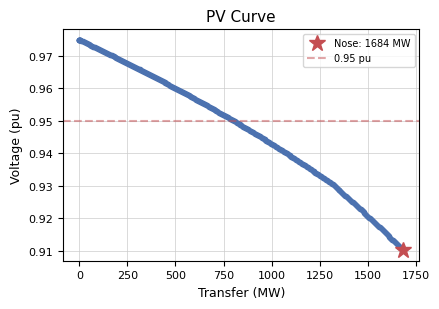

<Axes: title={'center': 'PV Curve'}, xlabel='Transfer (MW)', ylabel='Voltage (pu)'>

In [15]:
plot_pv_curve(mw_points, v_points)